Imports and other setup

set_node_attributes was not working for me with networkx 2.0 [see issue here](https://github.com/USEPA/WNTR/issues/29), so downgraded to 1.11 to get it running.

In [1]:
import math
from itertools import cycle
import pandas as pd
import numpy as np
import networkx as nx
from visJS2jupyter import visJS_module
import community
import matplotlib.pyplot as plt

# For display purposes
%matplotlib inline
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 800)

Setup paths, "global" variables, etc

In [2]:
edges_path = '../outputs/edges.csv'
orgs_path = '../outputs/org_names.csv'
output_path = './'
debug = False
# my_nrows = 200 # for testing
my_nrows = None # run on all rows

Define custom color function for good discrete node colors  
It has to be in this weird string format for visJS2jupyter  
See `return_node_to_color` in [visJS_module.py](https://pypkg.com/pypi/visjs2jupyter/f/visJS2jupyter/visJS_module.py) for the normal method  

In [3]:
def my_node_to_color(G,field_to_map='degree'):
    nodes_with_data = [(n[0], max(n[1][field_to_map], 0)) for n in G.nodes(data=True)]

    nsteps=20
    color_order=[0,2,4,6,8,10,12,14,16,18,1,3,5,7,9,11,13,15,17,19]
    cmap=plt.get_cmap("tab20")
    alpha = 1.0
    
    color_list_raw = cmap(np.linspace(0, 1, nsteps)) 
  
    nodes,data = zip(*nodes_with_data)
    data = [color_order[d] for d in data]
    nodes_with_data = zip(nodes,data)

    node_to_mapField = dict(nodes_with_data)
    color_list = [color_list_raw[node_to_mapField[d]] for d in G.nodes()]
    
    color_list = [(int(256*c[0]),int(256*c[1]),int(256*c[2]),alpha) for c in color_list]
    node_to_color = dict(zip(list(G.nodes()),['rgba'+str(c) for c in color_list]))

    return node_to_color

Read in human readable names, create usable dicts / symbols of them

In [4]:
df_org = pd.read_csv(orgs_path, dtype={
'ORGANIZATIONAL_UNIT': int,
'SCHOOL_NAME': object,
'ORG_DISPLAY_NAME': object
})
df_org_index = df_org.set_index('ORGANIZATIONAL_UNIT')

df_org_names = df_org_index[['ORG_DISPLAY_NAME']]
org_names = df_org_names.to_dict()['ORG_DISPLAY_NAME']

df_school_names = df_org_index[['SCHOOL_NAME']]
school_names = df_school_names.to_dict()['SCHOOL_NAME']

# Autogenerate
#school_names_list = list(df_org_index['SCHOOL_NAME'].unique())
#symbol_list = ["dot", "diamond", "star", "triangle", "triangleDown", "square"]
#school_symbols = {k: v for k, v in zip(school_names_list, cycle(symbol_list))}

# just hard code to group up rarer ones
school_symbols={
 'Trinity College of Arts & Sciences': 'dot',
 'Pratt School of Engineering': 'square',
 'School of Medicine': 'triangleDown',
 'School of Nursing': 'triangle',
 'Nicholas School of the Environment': 'diamond',
 "Institutes and Provost's Academic Units": 'star',
 'Sanford School of Public Policy': 'star',
 'Divinity School': 'star',
 'Duke Law School': 'star',
 'Fuqua School of Business': 'star'
}

Read in edges from csv

In [5]:
if debug:
    if(my_nrows is not None): print "Reading first %d rows of %s" % (my_nrows, edges_path)
    else: print "Reading all rows of %s" % (edges_path)
# need to specify dtypes manually when reading many rows...
# otherwise pandas wants to try to load all the rows into memory before inferring the dtype and you get a warning
df_edges = pd.read_csv(edges_path, dtype={
'Date': object,
'n1': int,
'n2': int
} , nrows=my_nrows)

Build graph G up explicitly, edge by edge. This way we can get the weights correct

In [6]:
G = nx.Graph()
default_weight = 1.0
#default_weight = 1.0 / float(len(df_edges.index))
for index, row in df_edges.iterrows():
    n1 = row['n1']
    n2 = row['n2']
    if G.has_edge(n1,n2):
        G[n1][n2]['weight'] += default_weight
    else:
        G.add_edge(n1,n2, weight=default_weight)

Create positions, community clusters

In [7]:
spring_pos = nx.spring_layout(G,k=2.5/math.sqrt(nx.number_of_nodes(G))) # 1/sqrt(n) is the default spacing par

In [8]:
parts = community.best_partition(G)
nx.set_node_attributes(G, 'parts', parts) 

Draw interactive graph!

In [9]:
nodes = G.nodes()
# node_to_color = visJS_module.return_node_to_color(G,field_to_map='parts',cmap=plt.get_cmap("jet"))
node_to_color = my_node_to_color(G,field_to_map='parts')

nodes_dict = [{"id":n,
               "title":("%s - %s" % (org_names[n],school_names[n])),
               #"title":org_names[n],
              "x":spring_pos[n][0]*1000,
              "y":spring_pos[n][1]*1000,
              #"color":"black",
              "color":node_to_color[n], 
               "node_shape":school_symbols[school_names[n]]
              } for n in nodes]
node_map = dict(zip(nodes,range(len(nodes)))) # map to indices for source/target in edges

In [10]:
edges_list = list(G.edges())
edge_to_color = visJS_module.return_edge_to_color(G,field_to_map='weight',
                                                  cmap=plt.cm.Greys,alpha = 1,color_vals_transform='log')
edges_dict = [{"source":node_map[edges_list[i][0]],
               "target":node_map[edges_list[i][1]],
               "title":"A",
               "edge_title_field":"B",
               "edge_label_field":"C",
               "color":edge_to_color[edges_list[i]] 
              }for i in range(len(edges_list))]

In [11]:
visJS_module.visjs_network(nodes_dict,edges_dict,
                           node_size_multiplier=8,node_font_size=0,
                           edge_width=9,
                           tooltip_delay = 0,
                           graph_width = 900,graph_height = 700,
                           graph_id = 0,
                           config_enabled=False)

List the members of the communities

In [12]:
df_communities = pd.DataFrame(parts.items(), columns=['ORGANIZATIONAL_UNIT', 'Community'])

In [13]:
## Pandas dataframe way
#from collections import defaultdict
#columns = defaultdict(list)
#for community in df_communities.Community.unique():
#        df_community = df_communities[df_communities['Community']==community]
#        for node in list(df_community['ORGANIZATIONAL_UNIT']):
#            columns[community].append(node)
#print columns
#df_community_lists = pd.DataFrame(dict([(col_name,pd.Series(values)) for col_name,values in columns.items() ]))
#df_community_lists

In [14]:
## Raw text
#for community in df_communities.Community.unique():
#        print community
#        df_community = df_communities[df_communities['Community']==community]
#        for n in list(df_community['ORGANIZATIONAL_UNIT']):
#            print "%s - %s" % (org_names[n],school_names[n])

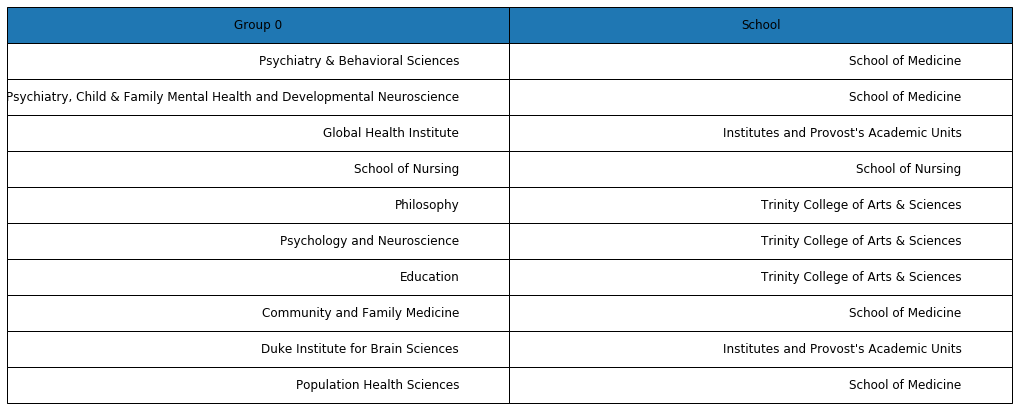

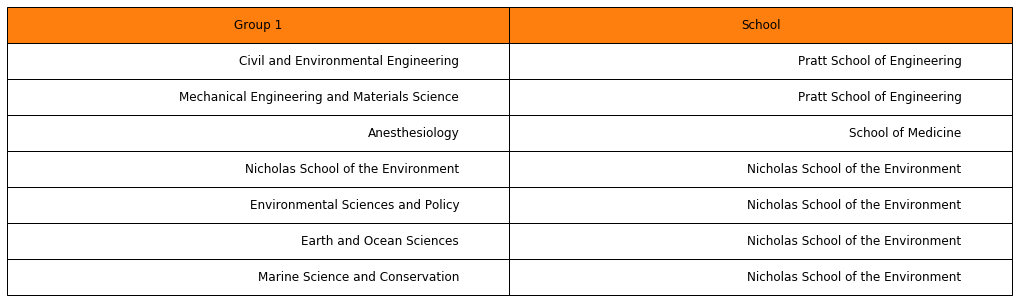

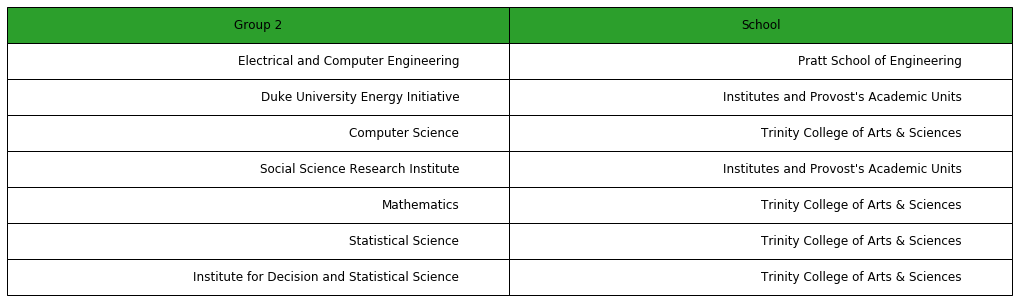

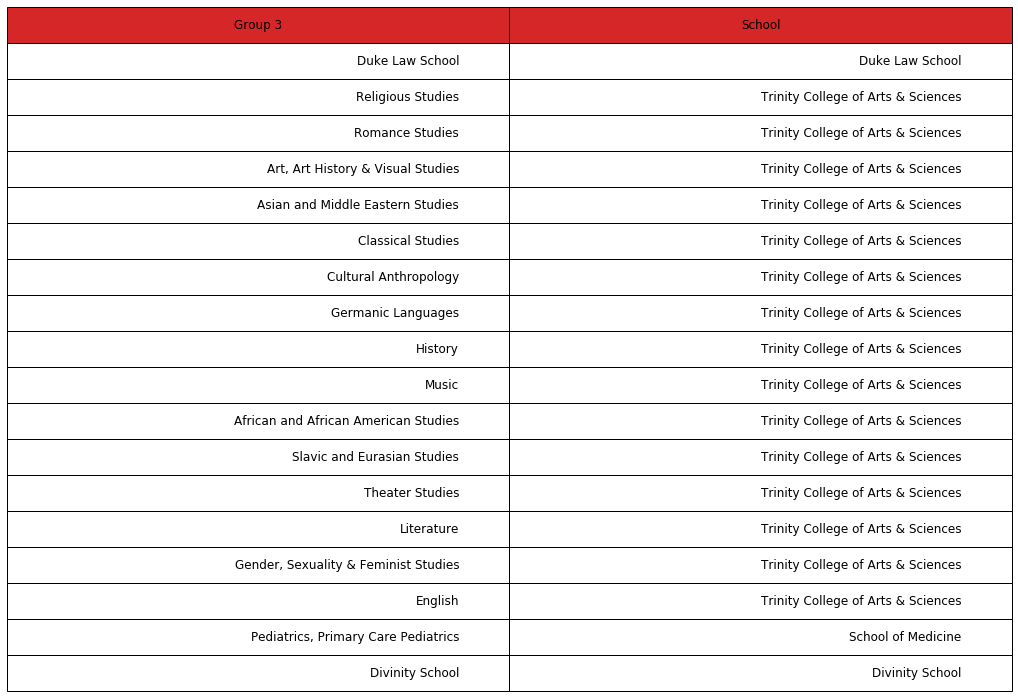

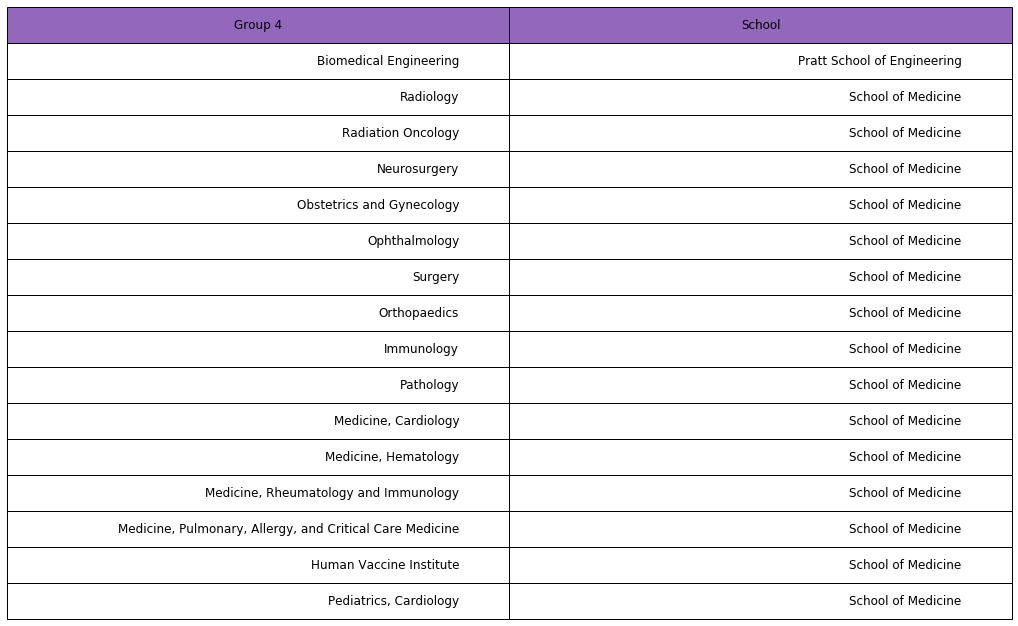

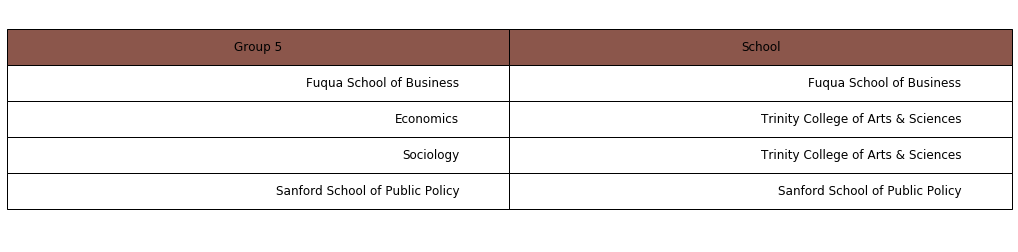

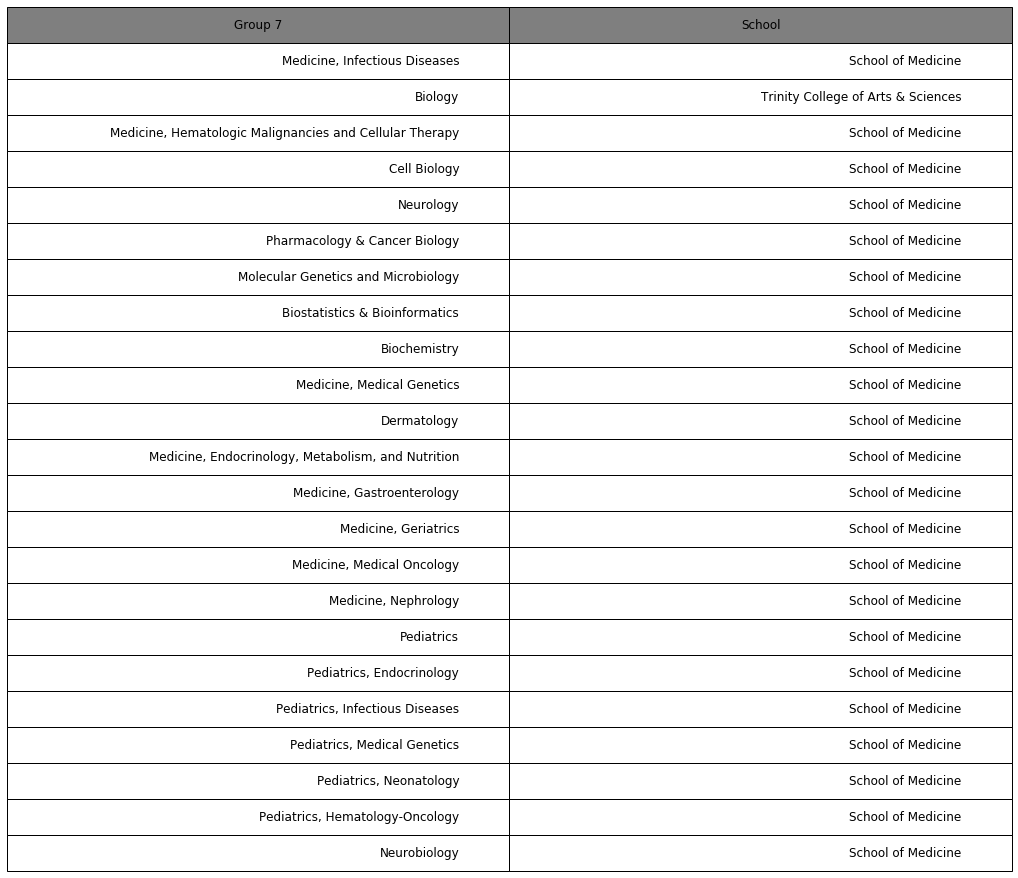

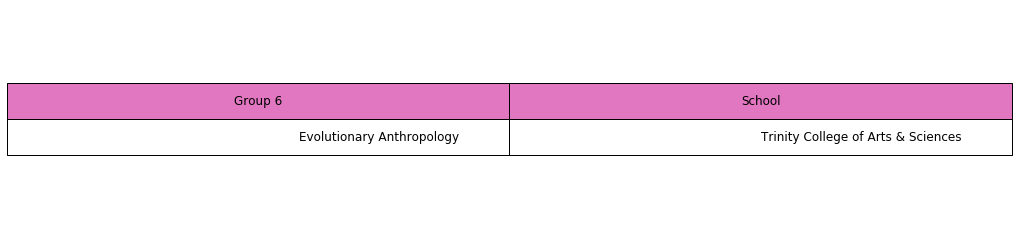

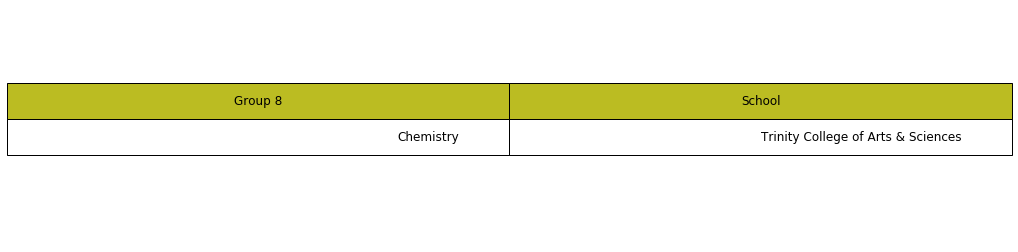

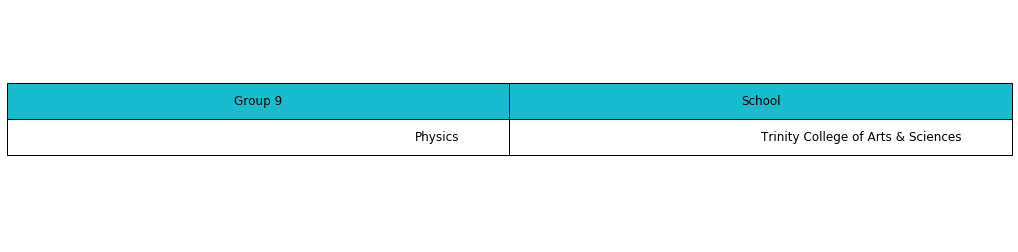

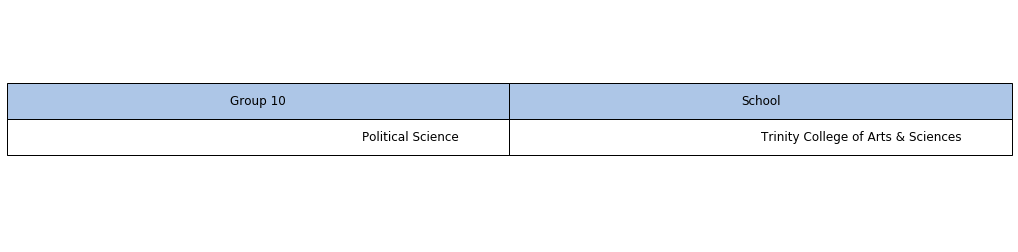

In [15]:
## As matplotlib tables, with color coded headers
from ast import literal_eval
for community in df_communities.Community.unique():
    df_community = df_communities[df_communities['Community']==community]
    cell_text = []
    first_n = -1
    for n in list(df_community['ORGANIZATIONAL_UNIT']):
        # cell_text.append([("%s - %s" % (org_names[n],school_names[n]))])
        cell_text.append([org_names[n], school_names[n]])
        if first_n == -1: first_n = n

    # sort out the weird color format...
    color_str = node_to_color[first_n].replace('rgba','')
    color_tuple_raw = literal_eval(color_str)
    color_tuple = [x / 256.0 for x in color_tuple_raw[:3]]
    color_tuple.append(color_tuple_raw[3])

    plt.axis('off')
    the_table = plt.table(cellText=cell_text,colLabels=[("Group %d" % community),"School"],
              colColours=[color_tuple,color_tuple],
              loc='center')
    the_table.scale(3,3)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)
    plt.show()